In [1]:
import numpy as np
from mikeio import Dfs0
from mikeio.eum import TimeStep, ItemInfo, EUMType, EUMUnit
from datetime import datetime, timedelta

# Create a timeseries

In [2]:
data = []

nt = 10
d1 = np.zeros(nt)
data.append(d1)
d2 = np.ones(nt)
data.append(d2)

items = [ItemInfo("Zeros", EUMType.Water_Level, EUMUnit.meter), 
         ItemInfo("Ones", EUMType.Discharge, EUMUnit.meter_pow_3_per_sec)]

dfs = Dfs0()

dfs.create(filename="test.dfs0", data=data, items=items, title="Zeros and ones",
           start_time=datetime(2000,1,1),
           timeseries_unit=TimeStep.SECOND, dt=3600)

## From comma separated file

In [3]:
import pandas as pd

df = pd.read_csv("../tests/testdata/co2-mm-mlo.csv", parse_dates=True,index_col='Date',na_values=-99.99)
df.head()

,Decimal Date,Average,Interpolated,Trend,Number of Days
Date,,,,,
1958-03-01,1958.208,315.71,315.71,314.62,-1
1958-04-01,1958.292,317.45,317.45,315.29,-1
1958-05-01,1958.375,317.50,317.50,314.71,-1
1958-06-01,1958.458,NaN,317.10,314.85,-1
1958-07-01,1958.542,315.86,315.86,314.98,-1


Remove missing values

In [4]:
df = df.dropna()

In [5]:
df = df[["Average","Trend"]]

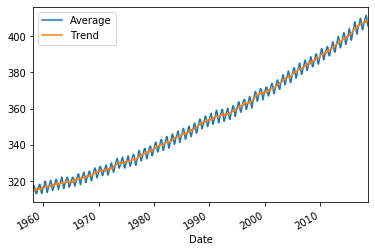

In [6]:
df.plot()

A dataframe with a datetimeindex can be used to create a dfs 0 with a non-equidistant time axis.

In [7]:
df.to_dfs0("mauna_loa_co2.dfs0")

To get a equidistant time axis first interpolate to hourly values.

In [8]:
df_h = df.resample('h').interpolate()

In [9]:
df_h.to_dfs0("mauna_loa_co2_eq_1hr.dfs0")

# Read a timeseries

In [10]:
res = dfs.read("test.dfs0")

In [11]:
res.items

[Zeros <Water Level> (meter), Ones <Discharge> (meter pow 3 per sec)]

In [12]:
res.time

[datetime.datetime(2000, 1, 1, 0, 0),
 datetime.datetime(2000, 1, 1, 1, 0),
 datetime.datetime(2000, 1, 1, 2, 0),
 datetime.datetime(2000, 1, 1, 3, 0),
 datetime.datetime(2000, 1, 1, 4, 0),
 datetime.datetime(2000, 1, 1, 5, 0),
 datetime.datetime(2000, 1, 1, 6, 0),
 datetime.datetime(2000, 1, 1, 7, 0),
 datetime.datetime(2000, 1, 1, 8, 0),
 datetime.datetime(2000, 1, 1, 9, 0)]

In [13]:
res.data

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]

## Or as a Pandas dataframe

In [14]:
dfs0file = r"../tests/testdata/da_diagnostic.dfs0"

dfs = Dfs0()
df = dfs.to_dataframe(dfs0file)
df.head()

,State 1Sign. Wave Height,State 2Sign. Wave Height,Mean StateSign. Wave Height,MeasurementSign. Wave Height
2017-10-27 00:00:00,1.749465,1.749465,1.749465,1.72
2017-10-27 00:10:00,1.811340,1.796895,1.807738,NaN
2017-10-27 00:20:00,1.863424,1.842759,1.853422,NaN
2017-10-27 00:30:00,1.922261,1.889839,1.897670,NaN
2017-10-27 00:40:00,1.972455,1.934886,1.935281,NaN


In [15]:
dfs0file = r"../tests/testdata/random.dfs0"

dfs = Dfs0()
df = dfs.to_dataframe(dfs0file)
df.head()

,VarFun01,NotFun
2017-01-01 00:00:00,0.843547,0.640486
2017-01-01 05:00:00,0.093729,0.653257
2017-01-01 10:00:00,NaN,NaN
2017-01-01 15:00:00,0.305065,0.214208
2017-01-01 20:00:00,0.900190,0.999157


## Create a timeseries with non-equidistant data

In [16]:
data = []

d1 = np.random.uniform(low=0.0, high=5.0, size=5)
data.append(d1)

datetimes = [
    datetime(2000, 1, 1, 0, 0),
    datetime(2000, 1, 8, 0, 0),
    datetime(2000, 1, 10, 0, 0),
    datetime(2000, 2, 22, 0, 0),
    datetime(2000, 11, 29, 0, 0)
]

dfs = Dfs0()


dfs.create(filename="neq.dfs0",
           datetimes=datetimes, 
           data=data,
           title="Non equidistant"
)

## Create a timeseries with accumulated timestep

## Find correct eum units

In [17]:
EUMType.search("prec")

[Correction of precipitation,
 Precipitation correction,
 Precipitation,
 Specific Precipitation,
 Precipitation Rate]

In [18]:
EUMType.Precipitation_Rate.units

[mm per day,
 mm per hour,
 cm per hour,
 meter per sec,
 meter per day,
 feet per day,
 inch per hour,
 inch per min,
 inch per day,
 mm per year]

In [19]:
from DHI.Generic.MikeZero.DFS import DataValueType
n= 1000
d1 = np.random.random([n])
d2 = np.random.random([n])
data = []
data.append(d1)
data.append(d2)
start_time = datetime(2017, 1, 1)
time_vector = []
t = start_time
random_dt = np.random.choice([1.0,2.0],size=n)
for i in range(n):
    t = t + timedelta(hours=random_dt[i])
    time_vector.append(t)
title = 'Hello Test'

items = [ItemInfo(EUMType.Water_Level), # use default name and unit based on type
        ItemInfo("Nedbør", EUMType.Precipitation_Rate)] # use a custom name

data_value_type = [DataValueType.Instantaneous, DataValueType.Accumulated]

dfs = Dfs0()
dfs.create(filename='accumulated.dfs0', data=data,
        datetimes=time_vector,
        items=items, title=title,
        data_value_type=data_value_type)

In [20]:
ds = dfs.read("accumulated.dfs0")
ds.items

[Water Level <Water Level> (meter), Nedbør <Precipitation Rate> (mm per day)]

# Modify an existing timeseries

The `write` method allows to modify the data without the need of specifying names, units etc. If you need to add variables, rename, change units, you must use `create` instead.

In [21]:
res = dfs.read("test.dfs0")
res

DataSet(data, time, items)
Number of items: 2
Shape: (10,)
2000-01-01 00:00:00 - 2000-01-01 09:00:00

In [22]:
res['Ones']

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Modify the data in some way...

In [23]:
data = res.data
data[1] = data[1]*np.pi
data[1]

array([3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265,
       3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265])

In [24]:
from shutil import copyfile
copyfile("test.dfs0","modified.dfs0")
dfs.write("modified.dfs0", data)

In [25]:
res = dfs.read("modified.dfs0")
res['Ones']

array([3.14159274, 3.14159274, 3.14159274, 3.14159274, 3.14159274,
       3.14159274, 3.14159274, 3.14159274, 3.14159274, 3.14159274])

The second item is modified.

In [26]:
res['Zeros']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Convert units

Read a file with waterlevel i meters.

In [27]:
dfs = Dfs0()
filename = r"C:\Program Files (x86)\DHI\2020\MIKE Zero\Examples\MIKE_21\FlowModel_FM\HD\Oresund\Data\1993\Boundary_Conditions\waterlevel_viken.dfs0"

ds = dfs.read(filename)
ds.items

[ST 2: WL (m) <Water Level> (meter)]

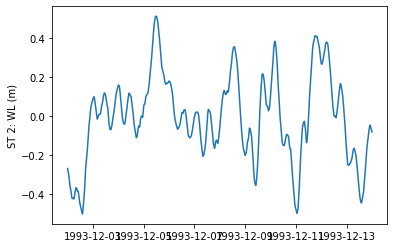

In [28]:
import matplotlib.pyplot as plt
plt.plot(ds.time,ds.data[0])
plt.ylabel(ds.items[0].name);

The aim is to convert this timeseries to feet (1m = 3.3 ft)

In [29]:
data = ds.data
data[0] = data[0]*3.3

Which units are acceptable?

In [30]:
ds.items[0].type.units

[meter,
 kilometer,
 centimeter,
 millimeter,
 feet,
 feet US,
 inch,
 inch US,
 mile,
 mile US,
 yard,
 yard US]

In [31]:
dfs = Dfs0()

items = ds.items
items[0].name = "Viken"
items[0].unit = EUMUnit.feet

dfs.create(filename='wl_feet.dfs0', data=ds.data,
           start_time=ds.time[0],
            dt = 1800,
            items=items)

![WL](https://github.com/DHI/mikeio/raw/master/images/wl_feet.png)

## Extrapolation

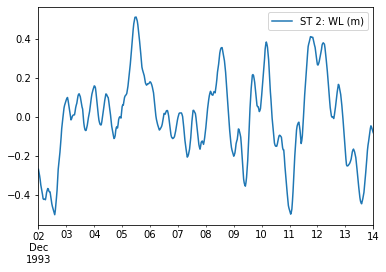

In [32]:
dfs = Dfs0()
filename = r"C:\Program Files (x86)\DHI\2020\MIKE Zero\Examples\MIKE_21\FlowModel_FM\HD\Oresund\Data\1993\Boundary_Conditions\waterlevel_viken.dfs0"

ds = dfs.read(filename)
df = ds.to_dataframe()
df.plot()

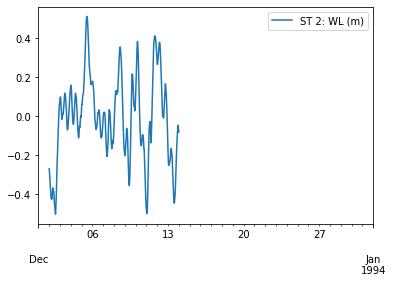

In [33]:
from datetime import date
rng = pd.date_range("1993-12-1","1994-1-1",freq='30t')
ix = pd.DatetimeIndex(rng)
dfr = df.reindex(ix)
dfr.plot()

Replace NaN with constant extrapolation (forward fill + back fill).

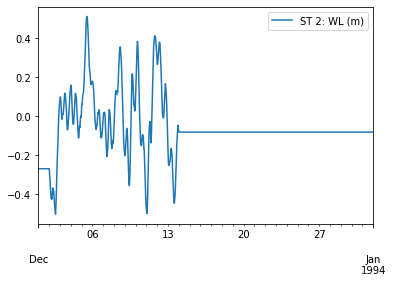

In [34]:
dfr = dfr.ffill().bfill()
dfr.plot()

In [35]:
dfr.to_dfs0("Viken_extrapolated.dfs0", items=ds.items, title="Caution extraplolated data!")

## Clean up

In [37]:
import os

os.remove("test.dfs0")
os.remove("modified.dfs0")
os.remove("neq.dfs0")
os.remove("accumulated.dfs0")
os.remove("wl_feet.dfs0")
os.remove("mauna_loa_co2_eq_1hr.dfs0")
os.remove("mauna_loa_co2.dfs0")
os.remove("Viken_extrapolated.dfs0")